# Librerias

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils as u
import re
import geopandas as gpd
import ast

pd.options.display.max_columns = None

# Limpieza de Datos

Nuestra base principal es la base de los restaurantes de google maps, lo que haremos será unificar las 4 fuentes en un mismo dataframe para poder modelar.

In [17]:
''' 
Lectura de datos de id de sitios y sus nombres.
'''

restaurantes = pd.read_csv('../data/raw/lugares_madrid.csv')

In [18]:
''' 
Lectura de datos de detalle de sitios de Madrid.
'''
detalle_restaurantes = pd.read_csv('../data/raw/detalle_sitios.csv')

In [19]:
restaurantes = pd.merge(restaurantes, detalle_restaurantes, left_on='id', right_on='place_id') # Unimos las 2 fuentes por el place_id

In [ ]:
restaurantes.drop(['id', 'summary'], inplace=True, axis=1) # Quitamos las  variables de id y summary de dataframe
restaurantes = restaurantes[restaurantes['rating'].notnull()] # Quitamos los restaurantes que tienen rating vacios

In [21]:
print('Distribución de precios:\n')
print(restaurantes['price_level'].value_counts(dropna=False), '\n')
print('Total de registros:', len(restaurantes['price_level']))

Distribución de precios:

price_level
1.0    1061
NaN     724
2.0     637
3.0     104
4.0      16
Name: count, dtype: int64 

Total de registros: 2542


In [22]:
''' 
Vamos hacer un proceso de limpieza para el dataframe y vamos a asumir cierto valores para los registros sin datos.
- todas las variables booleanas según cada un asumiremos que los valores vacios son verdaderos o falsos.
- dine_in: Comer dentro del restaurante todos los vacios asumimos que son True (lo más común).
- reservable: Si se puedo o no hacer reservas es dificil determinar su valor pero asumimos que es Falso. 
- serves_beer: Si sirve cerveza, asumimos que siempre. 
- serves_breakfast: Sirven desayunos, asumimos que no ya que lo común es que sea almuerzos o cena. 
- serves_brunch:Sirven brunch, asumimos que no ya que lo común es que sea almuerzos o cena. 
- serves_dinner: Sirven cena, asumimos que si ya que lo común es que sea almuerzos o cena. 
- serves_lunch: Sirven almuerzo, asumimos que si ya que lo común es que sea almuerzos o cena. 
- serves_vegetarian_food: Sirven comida vegetariana, asumimos que no ya que no es aun tan común aquí en Madrid. 
- serves_wine: Si sirve vino, asumimos que siempre.
- takeout: Si sirven para llevar asumimos que si suelen permitir.
- delivery: Asumimos que no hacen delivery.
- price_level: para el precio asumimos que tiene el precio que más se repite que es
'''
moda_open = restaurantes['hours_open'].mode()[0]

restaurantes['dine_in'] = restaurantes['dine_in'].astype(bool).fillna(True).astype(int)
restaurantes['price_level'] = restaurantes['price_level'].fillna(1)
restaurantes['reservable'] = restaurantes['reservable'].astype(bool).fillna(False).astype(int)
restaurantes['serves_beer'] = restaurantes['serves_beer'].astype(bool).fillna(True).astype(int)
restaurantes['serves_breakfast'] = restaurantes['serves_breakfast'].astype(bool).fillna(False).astype(int)
restaurantes['serves_brunch'] = restaurantes['serves_brunch'].astype(bool).fillna(False).astype(int)
restaurantes['serves_dinner'] = restaurantes['serves_dinner'].astype(bool).fillna(True).astype(int)
restaurantes['serves_lunch'] = restaurantes['serves_lunch'].astype(bool).fillna(True).astype(int)
restaurantes['serves_vegetarian_food'] = restaurantes['serves_vegetarian_food'].astype(bool).fillna(False).astype(int)
restaurantes['serves_wine'] = restaurantes['serves_wine'].astype(bool).fillna(True).astype(int)
restaurantes['takeout'] = restaurantes['takeout'].astype(bool).fillna(True).astype(int)
restaurantes['delivery'] = restaurantes['delivery'].astype(bool).fillna(False).astype(int)
restaurantes['weelchair'] = restaurantes['weelchair'].astype(bool).fillna(False).astype(int)
restaurantes['hours_open'] = restaurantes['hours_open'].fillna(moda_open)
restaurantes['open_weekends'] = restaurantes['open_weekends'].astype(int)

In [23]:
restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2542 entries, 0 to 2627
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nombre                  2542 non-null   object 
 1   lat                     2542 non-null   float64
 2   lon                     2542 non-null   float64
 3   place_id                2542 non-null   object 
 4   dine_in                 2542 non-null   int64  
 5   address                 2542 non-null   object 
 6   price_level             2542 non-null   float64
 7   rating                  2542 non-null   float64
 8   reservable              2542 non-null   int64  
 9   serves_beer             2542 non-null   int64  
 10  serves_breakfast        2542 non-null   int64  
 11  serves_brunch           2542 non-null   int64  
 12  serves_dinner           2542 non-null   int64  
 13  serves_lunch            2542 non-null   int64  
 14  serves_vegetarian_food  2542 non-null   int64

Una vez con todos los valores sin nulos, vamos a crear una variables para el modelo basadas en las localización del restaurante, para esto tenemos que primero tansformar el dataframe en un dataframe geo espacial de Geopandas.

In [24]:
''' 
Creamos un dataframe geoespacial donde los puntos de geometria es la latitud y logitud. Esta medidas tiene un valor de crs 
(Coordinate Reference System of the geometry objects) de 4326 que hace referencia a la latitud y logitud.
'''

restaurantes_geo = gpd.GeoDataFrame(restaurantes, geometry=gpd.points_from_xy(restaurantes['lon'], restaurantes['lat']), crs='EPSG:4326')

Una vez convertido en geopandas, primero vamos hacer un mapping a que barrio y distrito pertenece cada restaurante. Para esto utilizaremos la información del ayuntamiento de Madrid que viene detallado en un json la geometría de cada barrio.

In [25]:
''' 
Lectura de geometria de barrios y las transformamos en geopandas con un crs de 4326 para poder mapear con nuestro dataframe de restaurantes_geo.
'''
barrios = gpd.read_file('../data/raw/Barrios.json') # lectura
barrios = gpd.GeoDataFrame(barrios, geometry='geometry', crs='EPSG:4326') # Determinar la geometria

In [270]:
'''
Una vez unficado las 2 fuentes en la misma métricas vamos a hacer un join espacial donde miramos de la geometria de los restaurantes en que barrio
se encuentra dentro o intersecan.
Quitamos variables que no necesitamos.
'''

restaurantes_geo = gpd.sjoin(restaurantes_geo, barrios, how='left', predicate='intersects')
restaurantes_geo.drop(['index_right', 'id', 'Shape_Leng', 'Shape_Area','FCH_ALTA', 
                       'FCH_BAJA', 'OBSERVACIO', 'APROBACION', 'COD_DIS_TX', 'COD_DISB',
                       'BARRIO_MAY','BARRIO_MT', 'COD_DISBAR', 'NUM_BAR'], axis=1 , inplace=True)

In [271]:
restaurantes = pd.merge(restaurantes, restaurantes_geo[['place_id', 'CODDIS', 'NOMDIS','COD_BAR', 'NOMBRE']], 
                        how='left', left_on='place_id', right_on='place_id')

Ahora que ya tenemos los barrios y distritos mapeados para cada restaurante, vamos a crear variables de:
- Media de precio de los restaurantes cerca de 500 m.
- Media de rating de los restaurantes cerca de 500 m.
- Media de comentarios de los restaurantes cerca de 500 m.

Para hace esto, tenemos que unir el dataframe geo espacial de restaurantes con la misma base, pero creamos un campo nuevo que hace un buffer (poligono geoespacial de todos los puntos dentro de un radio) de manera que se pueda mirar que restaurantes están dentro de este radio.

Para esto tenemos que cambiar la geometría de dataframe a un crs de 25830 seudonimo en distancia en metros.

In [219]:
restaurantes_geo = restaurantes_geo.to_crs(epsg=25830) #cambiar lat y log a seudonimo en distancia en metros para España

In [220]:
''' 
Creamos una copia del dataframe de restarantes para crearlo con el buffer de los 500 m.
'''
restaurantes_geo_buffer = restaurantes_geo.copy() #copia de df
restaurantes_geo_buffer['buffer_500'] = restaurantes_geo_buffer.geometry.buffer(500) #creamos el campo de buffer
restaurantes_geo_buffer = restaurantes_geo_buffer.set_geometry('buffer_500') #cambiamos la geometría del dataframe para que sea el buffer

In [221]:
restaurantes_geo.drop(['nombre','lat', 'lon', 'dine_in', 'address', 'reservable', 'serves_beer', 'serves_breakfast',
       'serves_brunch', 'serves_dinner', 'serves_lunch',
       'serves_vegetarian_food', 'serves_wine', 'takeout', 'delivery',
       'CODDIS', 'NOMDIS','COD_BAR', 'NOMBRE'], axis=1, inplace=True) #quitamos ciertas variables para que no se repitan

In [222]:
'''
Una vez unficado los 2 dataframes  en la misma métricas vamos a hacer un join espacial donde miramos de la geometria de los restaurantes en que barrio
se encuentra dentro o intersecan.
Quitamos variables que no necesitamos.
'''

result_restaurantes = gpd.sjoin(restaurantes_geo, restaurantes_geo_buffer, how='right', predicate='intersects')
result_restaurantes.drop('index_left', axis=1, inplace=True)
result_restaurantes = result_restaurantes[result_restaurantes['place_id_right'] != result_restaurantes['place_id_left']] #quitamos los id del mismo sitio

In [223]:
''' 
Una vez unidos vamos a agrupar por restaurante y calculamos las medidas antes mencionadas.
- Media de precio de los restaurantes cerca de 500 m.
- Media de rating de los restaurantes cerca de 500 m.
- Media de comentarios de los restaurantes cerca de 500 m.
'''

result = result_restaurantes.groupby(['place_id_right'])[['price_level_left', 'rating_left', 'user_ratings_total_left']].mean().reset_index()
result2 = result_restaurantes.groupby(['place_id_right'])[['place_id_left']].count().reset_index()

result = pd.merge(result, result2, left_on=['place_id_right'], right_on=['place_id_right'])

In [224]:
result.rename({'place_id_right':'place_id',
               'price_level_left':'price_level_mean',
               'rating_left':'rating_mean',
               'user_ratings_total_left':'user_ratings_mean',
               'place_id_left':'num_restaurantes'}, axis=1, inplace=True)

In [225]:
restaurantes = pd.merge(restaurantes, result, how='left', left_on='place_id', right_on='place_id') # Unimos las nuevas columnas en nuestro df de restaurantes

In [226]:
restaurantes.fillna(0, inplace=True) # Rellenamos los null con 0 no tienen restaurantes a 500 m

In [227]:
restaurantes['COD_BAR'] = restaurantes['COD_BAR'].astype('int') # Quitamos los ceros antes de los codigos de barrio
restaurantes['COD_BAR'] = restaurantes['COD_BAR'].astype('str')

Ahora que ya tenemos los códigos de barrios mapeado para cada restaurante, podemos unir con la información de distintos indicadores de cada barrio de Madrid. Con esta fuente podemos tenemos una idea de tipo de vida media que tienen cada sitio.

In [228]:
''' 
Lectura de datos de kpi de barrios Madrid.
'''

kpi = pd.read_csv('../data/raw/kpi_barrios_madrid.csv')

In [229]:
kpi['cod_barrio'] = kpi['cod_barrio'].astype('int') # Quitamos los ceros antes de los codigos de barrio
kpi['cod_barrio'] = kpi['cod_barrio'].astype('str')

In [230]:
''' 
Al ser una fuente de España los decimales se marcan con , y tenemos que reemplazarlos con .
'''

kpi['valor_indicador'] = kpi['valor_indicador'].str.replace(',', '.').astype('float')
kpi['valor_indicador'] = kpi['valor_indicador'].fillna(0) #rellenamos los datos vacios con 0

In [231]:
''' 
Pivotamos la tabla para que los indicadores sea columnas y las rellenamos con 0 los nulls.
'''

kpi = kpi.pivot(index='cod_barrio', columns='indicador_completo', values='valor_indicador').reset_index()
kpi.fillna(0, inplace=True)

In [232]:
''' 
Nos quedamos solo con algunas variables.
'''

kpi = kpi[[ 'cod_barrio', 
            'Año medio de contrucción de inmuebles de uso residencial',
            'Duración media del crédito (meses) en transacción de vivienda',
            'Edad media de la población',
            'Número de locales dados de alta abiertos',
            'Número de locales dados de alta cerrados',
            'Población densidad (hab./Ha.)',
            'Renta disponible media por persona',
            'Tasa de crecimiento demográfico (porcentaje)',
            'Valor catastral medio por inmueble de uso residencial']]

In [233]:
restaurantes = pd.merge(restaurantes, kpi, how='left', left_on='COD_BAR', right_on='cod_barrio') # Unimos los indicadores en la base de restaurantes

Ahora nos queda solo unir una fuente más para nuestra base de restaurantes, que es el tipo de cocina. Esta información no viene desde google maps, por lo que acudimos a Open Street Map, pero el problema principal es que estos datos al ser una API gratuita depende de voluntarios y usuarios que suben los datos por lo que los datos no siempre están completos ni actualizados, por lo que usaremos estos datos para crear un modelo predictivo de clasificación que identifique por le nombre del restaurante el tipo de comida que vende.

In [234]:
''' 
Lectura de datos de reataurantes de toda España.
'''

street_map = pd.read_csv('../data/raw/sitios_streetmap.csv')

In [235]:
street_map = street_map[(street_map['cocina'].notnull())&(street_map['nombre'].notnull())] # nos quedamos con los registros que la cocina no sea vacia ni su nombre

In [236]:
street_map['cocina'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in street_map['cocina']] # Hacemos una limpieza previa del tipo de cocina para quitar los caracteres especiales

In [237]:
''' 
Hemos creado una diccionario que mapea el tipo de cocina con una agrupación de cada cocina. 
Este archivo lo cargamos y lo leemos como diccionario.
'''

with open('../data/raw/tipo_cocina.txt', 'r', encoding="utf-8") as file:
    data = file.read()

tipos_cocina = ast.literal_eval(data) #Convertimos a diccionario

In [238]:
''' 
Mapeamos en el data frame de open street map el tipo de cocina y nos quitamos los registro nulos.
'''

street_map['cocina_map'] = street_map['cocina'].map(tipos_cocina)
street_map = street_map[street_map['cocina_map'].notnull()]

In [239]:
''' 
Limpieza de nombre de restaurante para el modelo, quitamos tildes y caracteres especiales.
'''

street_map['nombre'] = street_map['nombre'].apply(u.eliminar_acentos)
street_map['nombre'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in street_map['nombre']]

Creamos un pipeline de distintos modelos para ver que mejor se ajusta a nuestro modelo.

In [240]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X = street_map['nombre']
y = street_map['cocina_map']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

pipe = Pipeline(steps=[("scaler", CountVectorizer()),
    ('classifier', MultinomialNB())
])

logistic_params = {
    'scaler':[CountVectorizer()],
    'classifier': [LogisticRegression(max_iter=10000, solver='liblinear'), LogisticRegression(max_iter=10, solver='liblinear')],
    'classifier__penalty': ['l1', 'l2']
}

random_forest_params = {
    'scaler': [CountVectorizer()],
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': np.arange(2, 9),
    'classifier__n_estimators': [100, 200, 500],
}

naive_param = {
    'scaler': [CountVectorizer()],
    'classifier': [MultinomialNB()],
    'classifier__alpha': [0.28, 0.30, 0.31],
}

cnaive_param = {
    'scaler': [CountVectorizer()],
    'classifier': [ComplementNB()],
    'classifier__alpha': [0.1, 0.25, 0.50, 0.75, 0.80, 1],
}

search_space = [
    logistic_params,
    random_forest_params,
    naive_param,
    cnaive_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 5,
                  n_jobs=-1)

clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=10000,
                                                            solver='liblinear'),
                                         LogisticRegression(max_iter=10,
                                                            solver='liblinear')],
                          'classifier__penalty': ['l1', 'l2'],
                          'scaler': [CountVectorizer()]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                          'classifier__n_estimators': [100, 200, 500],
                          'scaler': [CountVectorizer()]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.28, 0.3, 0.31],
                          'scaler': [CountVectorizer()]},
                         {'classifier': [ComplementNB()],
                          'classifier__alpha': [0.1, 0.25, 0.5, 0.75, 0.8, 1],
                          'scaler': [CountVectorizer()]}])

In [241]:
''' 
De todos los modelos que probamos usaremos el modelo de MultinomialNB (bayesianos), que son los que mejor se 
ajustan a modelos de prediccion de textos. 

'''

print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('scaler', CountVectorizer()),
                ('classifier', MultinomialNB(alpha=0.3))])
0.7347621613278077
{'classifier': MultinomialNB(), 'classifier__alpha': 0.3, 'scaler': CountVectorizer()}


In [242]:
''' 
Evaluamos el modelo en nuestro test.
'''

cocina_mod = clf.best_estimator_
y_pred = cocina_mod.predict(X_test)

cocina_mod.score(y_test, y_pred)

0.769690927218345

Nuestro modelo no es del todo preciso pero vamos a trabajar con el para nuestro modelo final, por lo que hacemos una nueva columna con el tipo de comida de cada restaurante.

In [243]:
''' 
Pre procesamos los datos de nombre del restaurantes para poder hacer la predicción  quitando las tildes y caracteres especiales.
'''

restaurantes['nombre'] = restaurantes['nombre'].apply(u.eliminar_acentos)
restaurantes['nombre'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in restaurantes['nombre']]

In [244]:
restaurantes['tipo_cocina']  = cocina_mod.predict(restaurantes['nombre']) # Creamos columna de tipo de cocina con el modelo

Según el modelo elegido para nuestro proyecto, ciertas varaibles es necesarios preprocesarlas para que se puedas incluir en la analítica. Estos preprocesos puedes ser convertir en dummies (Una variable que solo toma dos valores → 0 o 1) o codificar sus nombres en numeros.

In [245]:
''' 
Proceso para crear las variables dummies de:
- Tipo de cocina.
- Nombre distrito.
- Nombre de barrio.
'''

from sklearn.preprocessing import OneHotEncoder

enc_cocina = OneHotEncoder(handle_unknown='ignore')
tip_coci= enc_cocina.fit_transform(restaurantes[['tipo_cocina']]).toarray()
tip_cocina_dummy = pd.DataFrame(tip_coci, columns=[cat for cat in enc_cocina.categories_[0]])

enc_distrito = OneHotEncoder(handle_unknown='ignore')
tip_distrito= enc_distrito.fit_transform(restaurantes[['NOMDIS']]).toarray()
tip_distrito_dummy = pd.DataFrame(tip_distrito, columns=[cat for cat in enc_distrito.categories_[0]])

enc_barrio = OneHotEncoder(handle_unknown='ignore')
tip_barrio= enc_barrio.fit_transform(restaurantes[['NOMBRE']]).toarray()
tip_barrio_dummy = pd.DataFrame(tip_barrio, columns=[cat for cat in enc_barrio.categories_[0]])

restaurantes = pd.concat([restaurantes, tip_cocina_dummy, tip_distrito_dummy, tip_barrio_dummy], axis=1)

In [246]:
restaurantes.drop(['cod_barrio', 'NOMDIS', 'NOMBRE'], axis=1, inplace=True) # quitamos ciertas columnas que no necesitamos.

In [247]:
''' 
Renombramos las columnas a nombres mas faciles.
'''

restaurantes.rename(columns={
                    'nombre':'nombre_restaurante',
                    'address':'direccion',
                    'CODDIS':'cod_distrito',
                    'COD_BAR':'cod_barrio',
                    'Año medio de contrucción de inmuebles de uso residencial':'anio_medio_constr_vivendas',
                    'Duración media del crédito (meses) en transacción de vivienda':'dur_media_credito_viviendas',
                    'Edad media de la población':'edad_media_poblacion',
                    'Número de locales dados de alta abiertos':'num_locales_alta_abiertos',
                    'Número de locales dados de alta cerrados':'num_locales_alta_cerrados',
                    'Población densidad (hab./Ha.)':'poblacion_densidad',
                    'Renta disponible media por persona':'renta_media_persona',
                    'Tasa de crecimiento demográfico (porcentaje)':'pct_crecimiento_demografico',
                    'Valor catastral medio por inmueble de uso residencial':'valor_catast_inmueble_residen' }, inplace=True)

In [248]:
''' 
Codificar la variable tipo de cocina en numeros.
'''

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
tipo_cocina_encoder = encoder.fit_transform(restaurantes['tipo_cocina'])
restaurantes['tipo_cocina_encoder'] = tipo_cocina_encoder

Hemos creado una nueva variable a predecir y por que no solo queremos predecir su rating sino tambien queremos dar una ponderación de los comentarios que tiene los restaurantes, para esto hemos usado una ponderación simpre entre el rating y sus comentario.
~~~
Ponderación(y) = rating x log(user_ratings_total+1)
~~~
La ventaja de usar esto es que se penaliza a tener pocos comentarios indiferentemente si tu rating es alto.

<span style="color:red"><b>Ejemplo:</b></span>


**Restaurante A:** rating = 5 y num_comentarios = 5
~~~
Ponderación(y) = 5 x log(5+1) = 8.95
~~~

**Restaurante B:** rating = 4,7 y num_comentarios = 100
~~~
Ponderación(y) = 4.7 x log(100+1) = 21.7
~~~
El restaurante B tiene más ponderación que el A por sus comentarios. 

In [249]:
restaurantes['y'] = restaurantes['rating']*(np.log(restaurantes['user_ratings_total']+1)) # Creamos la variable y o de ponderación.

La distribución de la variable a predecir es casi normal con un sezgo a la derecha, lo que nos dice que nuestras regresiones serán buenas.

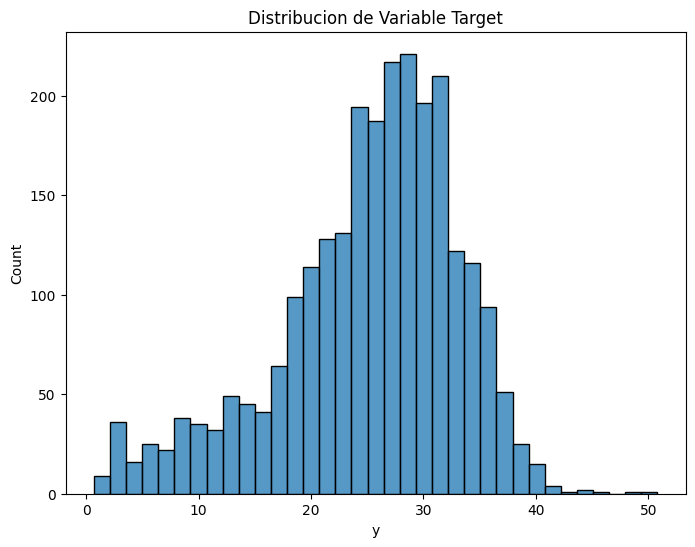

In [250]:
plt.figure(figsize=(8,6))
sns.histplot(restaurantes['y'])
plt.title(label='Distribucion de Variable Target')
plt.show() #distribución de variable Y

In [251]:
restaurantes.describe()

,lat,lon,dine_in,price_level,rating,reservable,serves_beer,serves_breakfast,serves_brunch,serves_dinner,serves_lunch,serves_vegetarian_food,serves_wine,takeout,user_ratings_total,delivery,weelchair,hours_open,num_days_open,open_weekends,price_level_mean,rating_mean,user_ratings_mean,num_restaurantes,anio_medio_constr_vivendas,dur_media_credito_viviendas,edad_media_poblacion,num_locales_alta_abiertos,num_locales_alta_cerrados,poblacion_densidad,renta_media_persona,pct_crecimiento_demografico,valor_catast_inmueble_residen,Americana / Burgers,Asiática,China,Española,Fusión,Italiana,Japonesa,Latinoamericana,Mexicana,Otros,Arganzuela,Carabanchel,Centro,Chamartín,Chamberí,Ciudad Lineal,Fuencarral - El Pardo,Hortaleza,Latina,Moncloa - Aravaca,Moratalaz,Puente de Vallecas,Retiro,Salamanca,Tetuán,Usera,Abrantes,Acacias,Adelfas,Almagro,Almenara,Almendrales,Aluche,Apóstol Santiago,Arapiles,Argüelles,Atalaya,Atocha,Bellas Vistas,Berruguete,Canillas,Casa de Campo,Castellana,Castilla,Castillejos,Chopera,Ciudad Jardín,Ciudad Universitaria,Colina,Comillas,Cortes,Costillares,Cuatro Caminos,Delicias,El Pardo,El Viso,Embajadores,Entrevías,Estrella,Fontarrón,Fuente del Berro,Fuentelarreina,Gaztambide,Goya,Guindalera,Hispanoamérica,Ibiza,Imperial,Justicia,La Concepción,La Paz,Legazpi,Lista,Los Cármenes,Los Jerónimos,Lucero,Marroquina,Media Legua,Mirasierra,Moscardó,Niño Jesús,Nueva España,Numancia,Opañel,Pacífico,Palacio,Palomeras Bajas,Palos de la Frontera,Peñagrande,Pilar,Pinar del Rey,Piovera,Portazgo,Pradolongo,Prosperidad,Puerta Bonita,Puerta del Ángel,Quintana,Recoletos,Ríos Rosas,San Diego,San Isidro,San Juan Bautista,San Pascual,Sol,Trafalgar,Universidad,Valdeacederas,Valdefuentes,Valdezarza,Vallehermoso,Valverde,Ventas,Vista Alegre,Zofío,tipo_cocina_encoder,y
count,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.00000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.00000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.00000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.00000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000
mean,40.429534,-3.697532,0.992132,1.351298,4.159559,0.933910,0.979544,0.802518,0.948466,0.986231,0.993706,0.409913,0.936271,0.976397,1183.399685,0.638867,0.895751,74.971263,6.120771,0.813533,1.348694,4.149971,1184.864633,29.383163,1965.476397,290.873721,45.628659,1010.579858,337.855232,247.698459,19239.016129,-1.198694,143806.180566,0.036979,0.009048,0.027537,0.685287,0.014162,0.081432,0.027537,0.007868,0.009835,0.10

In [252]:
corr = restaurantes.corr(numeric_only=True)

In [253]:
''' 
Evaluamos las correlaciones y nos quedamos con las variables que tengan un correlacion >=(abs(0.2))
'''

val = corr[(corr['y']>=0.2)|(corr['y']<=-0.2)].sort_values(by='y')
val
#val.to_excel('../data/raw/correlaciones.xlsx') 

,lat,lon,dine_in,price_level,rating,reservable,serves_beer,serves_breakfast,serves_brunch,serves_dinner,serves_lunch,serves_vegetarian_food,serves_wine,takeout,user_ratings_total,delivery,weelchair,hours_open,num_days_open,open_weekends,price_level_mean,rating_mean,user_ratings_mean,num_restaurantes,anio_medio_constr_vivendas,dur_media_credito_viviendas,edad_media_poblacion,num_locales_alta_abiertos,num_locales_alta_cerrados,poblacion_densidad,renta_media_persona,pct_crecimiento_demografico,valor_catast_inmueble_residen,Americana / Burgers,Asiática,China,Española,Fusión,Italiana,Japonesa,Latinoamericana,Mexicana,Otros,Arganzuela,Carabanchel,Centro,Chamartín,Chamberí,Ciudad Lineal,Fuencarral - El Pardo,Hortaleza,Latina,Moncloa - Aravaca,Moratalaz,Puente de Vallecas,Retiro,Salamanca,Tetuán,Usera,Abrantes,Acacias,Adelfas,Almagro,Almenara,Almendrales,Aluche,Apóstol Santiago,Arapiles,Argüelles,Atalaya,Atocha,Bellas Vistas,Berruguete,Canillas,Casa de Campo,Castellana,Castilla,Castillejos,Chopera,Ciudad Jardín,Ciudad Universitaria,Colina,Comillas,Cortes,Costillares,Cuatro Caminos,Delicias,El Pardo,El Viso,Embajadores,Entrevías,Estrella,Fontarrón,Fuente del Berro,Fuentelarreina,Gaztambide,Goya,Guindalera,Hispanoamérica,Ibiza,Imperial,Justicia,La Concepción,La Paz,Legazpi,Lista,Los Cármenes,Los Jerónimos,Lucero,Marroquina,Media Legua,Mirasierra,Moscardó,Niño Jesús,Nueva España,Numancia,Opañel,Pacífico,Palacio,Palomeras Bajas,Palos de la Frontera,Peñagrande,Pilar,Pinar del Rey,Piovera,Portazgo,Pradolongo,Prosperidad,Puerta Bonita,Puerta del Ángel,Quintana,Recoletos,Ríos Rosas,San Diego,San Isidro,San Juan Bautista,San Pascual,Sol,Trafalgar,Universidad,Valdeacederas,Valdefuentes,Valdezarza,Vallehermoso,Valverde,Ventas,Vista Alegre,Zofío,tipo_cocina_encoder,y
serves_breakfast,-0.018643,-0.053890,0.034117,-0.321273,-0.114022,0.015206,0.060949,1.000000,0.335805,0.034667,0.035489,-0.002458,0.109258,0.105132,-0.132816,-0.115802,0.134741,0.366183,-0.076876,-0.161379,-0.226197,-0.057893,-0.178088,-0.048531,0.149445,0.123264,-0.004645,-0.074017,0.101433,-0.039074,-0.123001,-0.107076,-0.110482,-0.080834,-0.025651,-0.079566,0.178769,0.026004,-0.137736,-0.091643,-0.000563,-0.080740,0.017624,-0.010937,0.086861,-0.119331,-0.047981,-0.073871,0.043125,0.049588,0.015363,0.059522,0.071558,-0.011845,0.039647,-0.003264,-0.043049,-0.059732,0.009402,0.003765,0.008459,-0.000397,-0.088266,-0.002540,-0.012461,0.012250,0.028579,0.014491,0.031563,-0.021323,0.027873,-0.002540,0.014481,-0.033702,0.040791,-0.023759,0.043106,-0.074353,-0.009085,-0.056486,0.034059,0.023441,0.007859,-0.050709,0.029126,-0.061862,-0.030672,0.009841,-0.021150,0.027994,-0.031970,0.035681,0.009841,-0.015215,0.019693,-0.034557,-0.011059,0.025013,-0.051269,-0.019661,-0.005248,-0.049065,0.019747,0.025054,0.005526,-0.047785,0.016455,-0.019848,0.031408,0.010230,-0.022932,0.003765,0.008459,-0.022994,-0.025562,0.034059,0.057600,0.013242,-0.080570,0.045275,-0.018992,0.030277,0.020507,0.023350,-0.039991,-0.016599,0.019693,-0.013970,0.007859,0.046913,-0.011646,-0.025912,-0.035358,0.020393,0.064109,-0.002540,0.007859,-0.030672,-0.060208,-0.076939,0.010211,0.012932,0.033416,0.021972,0.017052,0.035536,0.028230,0.013920,-0.029672,-0.315270
anio_medio_constr_vivendas,0.179012,0.096821,-0.027062,-0.261189,-0.054072,-0.003576,-0.005133,0.149445,0.040271,-0.033483,-0.018350,0.052176,-0.046231,0.048067,-0.268054,0.054962,0.149391,0.078183,0.003986,-0.060738,-0.506666,-0.123972,-0.687938,-0.307845,1.000000,0.513262,-0.086170,-0.581153,0.031630,-0.324372,-0.125755,-0.250238,-0.199840,0.036584,0.027426,0.033732,-0.069401,0.045130,0.031585,0.053561,0.003121,-0.045040,-0.004519,0.227076,0.128156,-0.749591,0.096011,-0.127789,0.186400,0.215820,0.149658,0.056991,-0.016363,0.062510,0.084975,-0.045064,-0.220207,0.069881,0.009387,0.022360,0.070269,0.074968,-0.043650,0.134711,0.042390,0.041576,0.052760,-0.070396,-0.147025,0.024901,0.145988,-0.042509,0.035618,0.059243,0.032313,-0.099872,0.069119,0.025804,-0.035669,0.01917

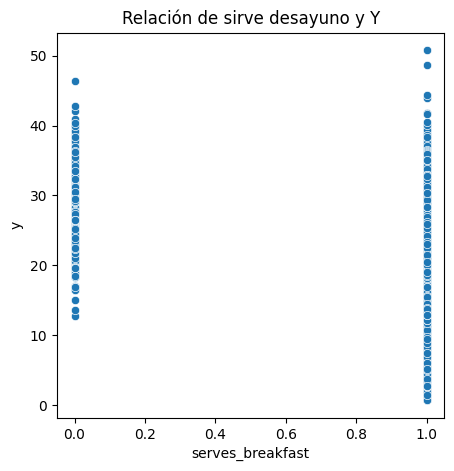

In [254]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['serves_breakfast'])
plt.title(label='Relación de sirve desayuno y Y')
plt.xlabel('serves_breakfast')
plt.ylabel('y')
plt.show()

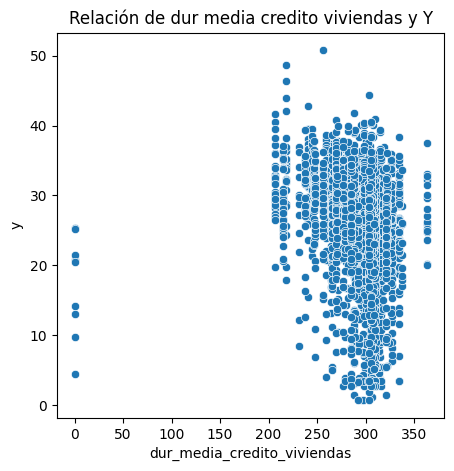

In [255]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['dur_media_credito_viviendas'])
plt.title(label='Relación de dur media credito viviendas y Y')
plt.xlabel('dur_media_credito_viviendas')
plt.ylabel('y')
plt.show()

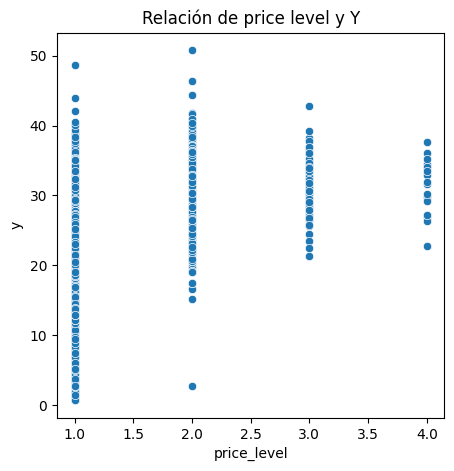

In [256]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['price_level'])
plt.title(label='Relación de price level y Y')
plt.xlabel('price_level')
plt.ylabel('y')
plt.show()

In [257]:
restaurantes.to_csv('../data/processed/restaurantes.csv', index=False)